# Strain and manifold analyses focused in individual protein examples: P48730 and P42530

## Importing libraries

In [4]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

from numba import jit
from scipy.ndimage import gaussian_filter1d

import psa.load as load
import psa.sequence as seq
import psa.elastic as elastic

## Loading filtered protein dataset

In [5]:
data = pd.read_csv("data/metadata/filtered_df.csv")
data

,UNIPROT,UNIPROT_RESIDUE_NUMBER,ENTRY_ID_ONE,AUTH_ASYM_ID_ONE,STRUCT_ASYM_ID_ONE,AUTH_SEQ_ID_ONE,PDB_SEQ_ID_ONE,CHEM_COMP_ONE,ENTRY_ID_TWO,AUTH_ASYM_ID_TWO,...,AUTH_SEQ_ID_TWO,PDB_SEQ_ID_TWO,CHEM_COMP_TWO,AUTH_FULL_ONE,AUTH_FULL_TWO,RENAMED_ASYM_ID_ONE,RENAMED_ASYM_ID_TWO,RENAMED_ENTITY_ONE,RENAMED_ENTITY_TWO,PHOSPHOSITE
0,P24941,160,2r3p,A,A,160.0,161,THR,5nev,C,...,160.0,165,TPO,2r3p_A,5nev_C,A,C,2r3p_A,5nev_C,P24941_160
1,P24941,160,2r3p,A,A,160.0,161,THR,2g9x,A,...,160.0,161,TPO,2r3p_A,2g9x_A,A,A,2r3p_A,2g9x_A,P24941_160
2,P24941,160,2r3p,A,A,160.0,161,THR,2wma,A,...,160.0,165,TPO,2r3p_A,2wma_A,A,A,2r3p_A,2wma_A,P24941_160
3,P24941,160,2r3p,A,A,160.0,161,THR,2uzb,A,...,160.0,160,TPO,2r3p_A,2uzb_A,A,A,2r3p_A,2uzb_A,P24941_160
4,P28482,187,4qp4,A,A,187.0,196,TYR,6opg,A,...,185.0,181,PTR,4qp4_A,6opg_A,A,A,4qp4_A,6opg_A,P28482_187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,P63086,183,6fle,A,A,183.0,189,THR,3zuv,C,...,183.0,189,TPO,6fle_A,3zuv_C,A,C,6fle_A,3zuv_C,P63086_183
135118,P25321,140,5m6y,A,A,139.0,142,SER,5n1g,A,...,139.0,142,SEP,5m6y_A,5n1g_A,A,A,5m6y_A,5n1g_A,P25321_140
135119,P25321,140,5m6y,A,A,139.0,142,SER,6eh2,A,...,139.0,142,SEP,5m6y_A,6eh2_A,A,A,5m6y_A,6eh2_A,P25321_140
135120,P24941,160,3qx2,A,A,160.0,168,THR,3bhv,C,...,160.0,162,TPO,3qx2_A,3bhv_C,A,C,3qx2_A,3bhv_C,P24941_160


## Creates dictionaries for Phosphorylated and Non-phosphorylated proteins for the each Uniprot entry

In [6]:
protP_accession = {}
protN_accession = {}
phosp_type = {}

psites = list(set(data["PHOSPHOSITE"]))
psites.sort()


for psite in psites:
    dataA = data[data["PHOSPHOSITE"] == psite]
    
    protein = psite.split("_")[0]
    
    protP_accession[psite] = list(set(dataA["AUTH_FULL_TWO"]))
    protN_accession[psite] = list(set(dataA["AUTH_FULL_ONE"]))
    phosp_type[psite] = list(set(dataA["CHEM_COMP_ONE"]))[0]

## Scatter plot style

In [7]:
def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    """
    Create a layered scatter plot on the given Axes object `ax`.

    Parameters:
    - ax: Matplotlib Axes object to draw on
    - xdata, ydata: Coordinates of the scatter points
    - color: Final visible color of the points
    - size: Size of the scatter points
    - lw: Line width for the black outline
    - alpha: Transparency of the final color layer
    """    
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return

## Loading functional dataset and assign specific indexes to functional sites

In [8]:
annot = pd.read_csv("data/metadata/uniprot_site_annotation.csv")

# Reformat missing data
annot = annot.replace(np.nan, "")

# Create a variable to describe each group of residues for a functional site
annot["group"] = annot["uniprot_id"] + ":" + annot["site_type"] + ":" + annot["description"] + ":" + annot["ligand"]

# Assign indexes for functional sites and Uniprot IDs
annot["site_idx"] = 0
annot["uniprot_idx"] = 0
for i in range(1, len(annot)):
    # For functional site
    if annot.iloc[i, 5] == annot.iloc[i-1, 5]:
        annot.iloc[i, 6] = annot.iloc[i-1, 6]
    else:
        annot.iloc[i, 6] = annot.iloc[i-1, 6] + 1
    
    # For Uniprot ID
    if annot.iloc[i, 0] == annot.iloc[i-1, 0]:
        annot.iloc[i, 7] = annot.iloc[i-1, 7]
    else:
        annot.iloc[i, 7] = annot.iloc[i-1, 7] + 1

# Number of different functional sites
annot_n = len(set(annot["site_idx"]))

# Uniprot IDs annotated
annot_uni = list(set(annot["uniprot_id"]))
annot_uni.sort()

annot

,uniprot_id,site_type,residue,description,ligand,group,site_idx,uniprot_idx
0,A0A0K8P8E7,Active site,225,Acyl-ester intermediate,,A0A0K8P8E7:Active site:Acyl-ester intermediate:,0,0
1,A0A0K8P8E7,Active site,492,Charge relay system,,A0A0K8P8E7:Active site:Charge relay system:,1,0
2,A0A0K8P8E7,Active site,528,Charge relay system,,A0A0K8P8E7:Active site:Charge relay system:,1,0
3,A0A0K8P8E7,Binding site,132,,4-[(2-hydroxyethoxy)carbonyl]benzoate,A0A0K8P8E7:Binding site::4-[(2-hydroxyethoxy)c...,2,0
4,A0A0K8P8E7,Binding site,226,,4-[(2-hydroxyethoxy)carbonyl]benzoate,A0A0K8P8E7:Binding site::4-[(2-hydroxyethoxy)c...,2,0
...,...,...,...,...,...,...,...,...
3120,Q9Y6E0,Binding site,114,,ATP,Q9Y6E0:Binding site::ATP,653,189
3121,Q9Y6E0,Binding site,161,,Mg(2+),Q9Y6E0:Binding site::Mg(2+),654,189
3122,Q9Y6E0,Binding site,174,,Mg(2+),Q9Y6E0:Binding site::Mg(2+),654,189
3123,Q9Y6E0,Site,325,Cleavage,,Q9Y6E0:Site:Cleavage:,655,189


## Support functions for PSA (Protein Strain Analysis)

In [13]:
def calculate_l3(p1, p2, outpath):
    """
    Computes the L3 (largest principal strain) profile between two aligned protein structures.

    Steps:
    1. Align sequences and extract coordinates.
    2. Compute deformation gradient and Lagrange strain tensor.
    3. Extract maximum principal stretches (L3).
    4. Select the top-N L3 sites minimizing correlation dimension.
    5. Save b-factor visualization of L3 values to output path.

    Parameters:
        p1 (str): Protein ID for structure 1.
        p2 (str): Protein ID for structure 2.
        outpath (str): Path to save b-factor colored structure.

    Returns:
        np.ndarray: Array of λ3 (stretch) values for each residue.
    """
    # Pairwise alignment of protein sequences
    com_res, dict_1, dict_2 = seq.pairwise_alignment(pps[p1], pps[p2])
        
    # Extract coordinates for aligned residues
    xyz_1, label_1 = load.coordinates(pps[p1], com_res, dict_1)
    xyz_2, label_2 = load.coordinates(pps[p2], com_res, dict_2)
        
    # Compute elastic weights for deformation gradient
    weights = elastic.compute_weights_fast([xyz_1, xyz_2], parameters=[12])
    F = elastic.deformation_gradient_fast(weights, xyz_1, xyz_2)
    
    # Compute strain tensor and extract principal stretches
    _, gam_n = elastic.lagrange_strain(F)
    stretches, _ = elastic.principal_stretches_from_g(gam_n)
    lambda3 = np.abs(stretches[:, 2]) ** 0.5  # largest principal stretch

    # Sort sites by λ3, compute correlation dimension for subsets
    order = np.argsort(lambda3)[::-1]
    Ns = range(10, len(lambda3))
    cd = np.zeros(len(Ns))

    for i, N in enumerate(Ns):
        cd[i] = correlation_dimension(N, xyz_1[order], xyz_2[order])
    
    # Select N that minimizes correlation dimension
    N = np.argmin(cd) + 10
    min_cd = np.argsort(lambda3)[::-1][:N]
    idx = get_idx(label_1)

    print(p1, "x", p2)
    print(list(idx[min_cd]), "\n")

    # Build a mapping from residue ID to λ3 value
    lambda3_dict = {}
    for j in range(len(lambda3)):
        id = label_1[j][0][:4]
        lambda3_dict[id] = lambda3[j]

    # Save b-factor-encoded structure
    fname = p1.split("_")[0]
    cname = p1.split("_")[1]
    load.save_bfactor(fname, lambda3_dict, "_" + cname + "_x_" + p2, outpath)

    return lambda3


def get_idx(labels):
    """
    Extract residue indices from label list.
    
    Parameters:
        labels (list): Nested label info from coordinate extraction.

    Returns:
        np.ndarray: Residue indices.
    """
    return np.array([label[0][3][1] for label in labels])


def compare_diff(ab_list, downsample=False, size=20, outpath="."):
    """
    Compare lambda 3 profiles for a list of protein pairs.

    Parameters:
        ab_list (list of tuples): List of (p1, p2) structure pairs.
        downsample (bool): Whether to downsample the list to number of pairs squared.
        size (int): Downsample size (only used if downsample = True).
        outpath (str): Directory to save results.

    Returns:
        np.ndarray: Array of L3 arrays for each comparison.
    """
    n = len(ab_list)

    if downsample and n > int(size**2):
        lambda3 = np.zeros(int(size**2), dtype=object)
        random = np.random.choice(n, int(size**2), replace=False)
        ab_list = [ab_list[i] for i in random]
    else:
        lambda3 = np.zeros(n, dtype=object)

    for c, (p1, p2) in enumerate(ab_list):
        lambda3[c] = calculate_l3(p1, p2, outpath)

    return lambda3

@jit(nopython=True)
def C(N, r, xyz_sorted):
    """
    Computes the correlation sum for a given radius r.

    Parameters:
        N (int): Number of points.
        r (float): Radius for neighborhood.
        xyz_sorted (np.ndarray): Coordinates (N, 3) sorted by importance.

    Returns:
        float: Normalized count of pairs within radius r.
    """
    heaviside_sum = 0
    for i in range(N):
        for j in range(i+1, N):
            dist = 0
            for k in range(3):
                dist += (xyz_sorted[i][k] - xyz_sorted[j][k]) ** 2
            dist = dist ** 0.5
            heaviside_sum += int(r > dist)
    return heaviside_sum / (N * (N - 1))

@jit(nopython=True)
def diam(xyz_sorted):
    """
    Computes the diameter (maximum pairwise distance) of a structure.

    Parameters:
        xyz_sorted (np.ndarray): Array of coordinates.

    Returns:
        float: Maximum pairwise distance.
    """
    diam = 0
    N = len(xyz_sorted)
    for i in range(N):
        for j in range(i+1, N):
            dist = 0
            for k in range(3):
                dist += (xyz_sorted[i][k] - xyz_sorted[j][k]) ** 2
            if dist > diam:
                diam = dist
    return diam ** 0.5

def smoothed_gradient(N, xyz_sorted):
    """
    Computes a smoothed gradient of the log correlation sum.

    Parameters:
        N (int): Number of points.
        xyz_sorted (np.ndarray): Coordinates sorted by stretch importance.

    Returns:
        tuple: (smoothed derivative values, corresponding radii)
    """
    r_range = np.linspace(8, diam(xyz_sorted), 60)
    Cs = np.array([C(N, r, xyz_sorted) for r in r_range])

    diff = np.zeros(len(r_range) - 1)
    r_vals = np.zeros(len(r_range) - 1)
    for i in range(len(Cs) - 1):
        rp, rm = r_range[i+1], r_range[i]
        r_vals[i] = (rp + rm) / 2
        diff[i] = (np.log(Cs[i+1]) - np.log(Cs[i])) / (rp - rm) * r_vals[i]

    r_int = np.linspace(r_vals[0], r_vals[-1], 1000)
    diff_int = np.interp(r_int, r_vals, diff)
    diff_smt = gaussian_filter1d(diff_int, 15)

    return diff_smt, r_int

def correlation_dimension(N, xyz1_sorted, xyz2_sorted):
    """
    Computes the average maximum slope of the log-log correlation curve
    for two structures.

    Parameters:
        N (int): Number of residues.
        xyz1_sorted, xyz2_sorted (np.ndarray): Sorted coordinates.

    Returns:
        float: Average max slope (correlation dimension).
    """
    grad1, _ = smoothed_gradient(N, xyz1_sorted)
    grad2, _ = smoothed_gradient(N, xyz2_sorted)
    return (np.max(grad1) + np.max(grad2)) / 2

def l3_profile(all_comparisons):
    """
    Aggregate L3 values across all comparisons into a residue-wise profile.

    Parameters:
        all_comparisons (list): Output of `compare_diff`, list of L3 arrays.

    Returns:
        tuple: (sorted residue IDs, mean L3 per residue, std deviation)
    """
    l3 = {}

    for comp in all_comparisons:
        if isinstance(comp, tuple):
            for res_id, res_l3 in zip(comp[2], comp[1]):
                l3.setdefault(res_id, []).append(res_l3)

    mean = np.zeros(len(l3))
    std = np.zeros(len(l3))
    res_ids = sorted(l3)

    for i, res_id in enumerate(res_ids):
        mean[i] = np.mean(l3[res_id])
        std[i] = np.std(l3[res_id])

    return res_ids, mean, std

In [14]:
# Build dictionary mapping phosphosites to P-N structure pairs
PN_list = {}
for group in data.groupby(["PHOSPHOSITE"]):
    df_group = group[1]
    psite = list(df_group["PHOSPHOSITE"])[0]
    P = list(df_group["AUTH_FULL_TWO"])   # Phosphorylated structures
    N = list(df_group["AUTH_FULL_ONE"])   # Non-phosphorylated
    PN_list[psite] = list(zip(P, N))

# PDB structure files to be used for coordinate extraction
cif_list = ["6msb", "7ahz", "7ai1", "7ai0", "3ocb", "3qkm", "6l9t", 
            "8i9x", "8i9z", "8ia0", "8bp2", "7z9t", "7z6i", "7q5i", 
            "3bcr", "6yve", "8atl", "6weu", "6wew", "6wet", "6wfj", 
            "6wev", "7p0k", "7z0n", "7z3l", "7z3k", "7und", "7unc", 
            "7q6h", "8idt", "8idy", "8flc", "8inf", "8flb", "8fla", 
            "7oa0", "6yum", "6yul", "6z83", "6z84", "6tlu"]


# Casein Kinase 1 - delta (P48730)

In [18]:
# Dictionary to hold loaded protein structures
pps = {}

# Define phosphosite and extract protein ID
psite = "P48730_220"
protein = psite.split("_")[0]
path = "data/PDB/" + protein + "/"

# Create output directory if it doesn't exist
outpath = "data/PDB_strain/" + psite + "/"
if not os.path.exists(outpath):
    os.mkdir(outpath)

# Load and store both non-phosphorylated and phosphorylated structures
for group in [protN_accession, protP_accession]:
    for accession in group[psite]:
        name, chain = accession.split("_")

        # Determine file type based on inclusion in known CIF list
        ft = "cif" if name in cif_list else "pdb"

        # Load structure
        structure = load.single_structure(name=name, 
                                          path=path,
                                          file_type=ft,
                                          chain_ids="*",
                                          relabel={chain: "*"})

        # Store loaded structure in dictionary
        pps[accession] = structure

        # Copy original file to output directory for downstream use or visualization
        source = path + name + "." + ft
        dest = outpath + name + "." + ft
        with open(source, 'rb') as src, open(dest, 'wb') as dst:
            dst.write(src.read())

## Create PDBs labelled with strain

In [ ]:
psite = "P48730_220"
compPN = compare_diff(PN_list[psite], False, 0, outpath)

## Calculate mean strain

In [20]:
psite = "P48730_220"
label = "PN"

file = "data/server/output_cd/" + psite + "_" + label + ".npy"
all_comparisons = np.load(file, allow_pickle = True)
res_ids, mean_l3, std_l3 = l3_profile(all_comparisons)

## Visualise strain profile

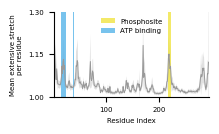

In [23]:
fig = plt.figure(figsize = (2, 1.1), dpi = 100)
ax = fig.add_subplot()

# Plot strain profile curve and shaded area for standard deviation
plt.plot(res_ids, mean_l3-1, color = "#999999", lw = .7)
plt.fill_between(res_ids, 
                 mean_l3 - 1 + std_l3/2, 
                 mean_l3 - 1 - std_l3/2, 
                 zorder = -1, alpha = .3, 
                 color = "#999999", lw = 0)

ylim = [0, 0.3]

# Define shaded areas for phosphosite and functional sites
plt.fill_betweenx(ylim, [219.5-2]*2, [220.5+2]*2, color = "#f0e442", alpha = .8, lw = 0, label = "Phosphosite")
plt.fill_betweenx(ylim, [14.5]*2, [23.5]*2, color = "#56b4e9", alpha = .8, lw = 0, label = "ATP binding")
plt.fill_betweenx(ylim, [37.5]*2, [38.5]*2, color = "#56b4e9", alpha = .8, lw = 0)
plt.legend(frameon = False, fontsize = 5, loc = "upper center")

# Figure layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    
plt.xlim(res_ids[0]-1, res_ids[-1]+1)
plt.ylim(ylim)
plt.yticks([0, .15, .3], ["1.00", "1.15", "1.30"], fontsize = 5)
plt.ylabel("Mean extensive stretch\nper residue", fontsize = 5)
plt.xticks([100, 200], fontsize = 5)
plt.xlabel("Residue index", fontsize = 5)
plt.show()

## Visualising the approach to calculate the correlation dimension profile and the high strain manifold

In [21]:
# Select a specific pair to calculate the correlation dimension
comp_pair = [("7p7f_B", "4hnf_A")]

# Compute the strain between structures
compPN = compare_diff(comp_pair, False, 0, outpath)
l3 = compPN[0]

# Load atomic coordinates
xyz1, _ = load.coordinates(pps[comp_pair[0][0]])
xyz2, _ = load.coordinates(pps[comp_pair[0][1]])

# Set a number of randomised trials for bootstrap
random_n = 40

# Create empty vectors for the correlation dimension
Ns = range(10, len(l3))
cd = np.zeros(len(Ns))
cd_r = np.zeros((len(Ns), random_n))

# Get an index reorder of residues based on a descending magnitude of strain
order = np.argsort(l3)[::-1]

for i, N in enumerate(Ns):
    # Calculate the correlation dimension for each residue
    cd[i] = correlation_dimension(N, xyz1[order], xyz2[order])

    # Calculte the correlation dimension for each residue with suffled atomic positions
    for r in range(random_n):
        np.random.seed(r)
        random = np.random.choice(len(l3), len(l3), replace = False)
        xyz1_r = xyz1[random]
        xyz2_r = xyz2[random]
        cd_r[i, r] = correlation_dimension(N, xyz1_r, xyz2_r)

7p7f_B x 4hnf_A
[75, 222, 3, 16, 43, 47, 22, 19, 4, 226, 225, 20, 14, 17, 18, 21] 



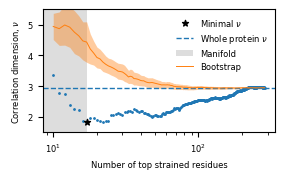

In [22]:
fig = plt.figure(figsize = (3, 1.6), dpi = 100)
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")

# Correlation dimension profile
ax.scatter(Ns, cd, s = 1)

# Determine the minimum correlation dimension
nmin = Ns[np.argmin(cd)]
ax.scatter(nmin, np.min(cd), color = "black", marker = "*", s = 20, label = "Minimal $\\nu$")

# Correlation dimension of the whole protein
ax.axhline(cd[-1], linestyle = "dashed", lw = 1, label = "Whole protein $\\nu$")

# Manifold of minimal deformation
ax.fill_between([0, nmin], 6, 0, zorder = -1, color = "#DDD", lw = 0, label = "Manifold")

# Defining the profile of bootstrapped correlation dimension
cd_r[~np.isfinite(cd_r)] = np.nan
mean_r = np.nanmean(cd_r, axis = 1)
std_r = np.nanstd(cd_r, axis = 1)
ax.plot(Ns, mean_r, color = "C1", label = "Bootstrap", lw = .7)
ax.fill_between(Ns, mean_r + std_r/2, mean_r - std_r/2, color = "C1", alpha = .4, lw = 0)

# Figure layout
plt.xlabel("Number of top strained residues", fontsize = 6)
plt.ylabel("Correlation dimension, $\\nu$", fontsize = 6)
plt.yticks([2, 3, 4, 5], fontsize = 6)
plt.xticks(fontsize = 6)
plt.legend(fontsize = 6, frameon = False)
plt.ylim(1.5, 5.5)
plt.show()

# Discoidin-2 (P42530)

In [24]:
# Dictionary to hold loaded protein structures
pps = {}

# Define phosphosite and extract protein ID
psite = "P42530_84"
protein = psite.split("_")[0]
path = "data/PDB/" + protein + "/"

# Create output directory if it doesn't exist
outpath = "data/PDB_strain/" + psite + "/"
if not os.path.exists(outpath):
    os.mkdir(outpath)

# Load and store both non-phosphorylated and phosphorylated structures
for group in [protN_accession, protP_accession]:
    for accession in group[psite]:
        name = accession.split("_")[0]
        chain = accession.split("_")[1]

        # Determine file type based on inclusion in known CIF list
        ft = "cif" if name in cif_list else "pdb"

        # Load structure
        structure = load.single_structure(name=name, 
                                          path=path,
                                          file_type=ft,
                                          chain_ids="*",
                                          relabel={chain: "*"})

        # Store loaded structure in dictionary
        pps[accession] = structure

        # Copy original file to output directory for downstream use or visualization
        source = path + name + "." + ft
        dest = outpath + name + "." + ft
        with open(source, 'rb') as src, open(dest, 'wb') as dst:
            dst.write(src.read())

## Create PDBs labelled with strain

In [ ]:
psite = "P42530_84"
compPN = compare_diff(PN_list[psite], False, 0, outpath)

## Calculate mean strain

In [25]:
label = "PN"

file = "data/server/output_cd/" + psite + "_" + label + ".npy"
all_comparisons = np.load(file, allow_pickle = True)
res_ids, mean_l3, std_l3 = l3_profile(all_comparisons)
print(len(all_comparisons))

18


## Visualise strain profile

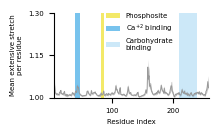

In [28]:
fig = plt.figure(figsize = (2, 1.1), dpi = 100)
ax = fig.add_subplot()

# Plot strain profile curve and shaded area for standard deviation
plt.plot(res_ids, mean_l3-1, color = "#999999", lw = .7)
plt.fill_between(res_ids, 
                 mean_l3 - 1 + std_l3/2, 
                 mean_l3 - 1 - std_l3/2, 
                 zorder = -1, alpha = .6, 
                 color = "#999999", lw = 0)

ylim = [0, 0.3]

# Define shaded areas for phosphosite and functional sites
plt.fill_betweenx(ylim, [83.5-2]*2, [84.5+2]*2, color = "#f0e442", alpha = .8, lw = 0, label = "Phosphosite")
plt.fill_betweenx(ylim, [38.5]*2, [47.5]*2, color = "#56b4e9", alpha = .8, lw = 0, label = "$\\rm Ca^{+2}$ binding")
plt.fill_betweenx(ylim, [208.5]*2, [238.5]*2, color = "#56b4e9", alpha = .3, lw = 0, label = "Carbohydrate\nbinding")
plt.legend(frameon = False, fontsize = 5, loc = (.32, .52))

# Figure layout
plt.xlim(res_ids[0]-1, res_ids[-1]+1)
plt.ylim(ylim)
plt.yticks([0, .15, .3], ["1.00", "1.15", "1.30"], fontsize = 5)
plt.ylabel("Mean extensive stretch\nper residue", fontsize = 5)
plt.xticks([100, 200], fontsize = 5)
plt.xlabel("Residue index", fontsize = 5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    
plt.show()
